[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)


In [ ]:
!git clone https://github.com/andreofner/pyGPC

Cloning into 'pyGPC'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 210 (delta 51), reused 32 (delta 10), pack-reused 72
Receiving objects: 100% (210/210), 1.29 MiB | 4.26 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
cd pyGPC

/content/pyGPC


In [ ]:
# The default setting will train on a single batch of the moving MNIST dataset
# In this setting pure inference (without weights optimization) leads to quite similar results
!python GPC.py

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2064384/45929032 bytes (4.5%)5472256/45929032 bytes (11.9%)8634368/45929032 bytes (18.8%)11952128/45929032 bytes (26.0%)15261696/45929032 bytes (33.2%)18227200/45929032 bytes (39.7%)21561344/45929032 bytes (46.9%)24690688/45929032 bytes (53.8%)27918336/45929032 bytes (60.8%)31203328/45929032 bytes (67.9%)34455552/45929032 bytes (75.0%)37601280/45929032 bytes (81.9%)

In [ ]:
# Moving MNIST train and test predictions
# Run this cell twice if videos don't show 

from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Train set
print("TRAIN DATA")
Image(open('./figures/insMnist-Train-v0.gif','rb').read())
print("Inputs\n")
Image(open('./figures/p_hMnist-Train-v0.gif','rb').read())
print("Prediction from states in all layers\n")
Image(open('./figures/p_gMnist-Train-v0.gif','rb').read())
print("Prediction from state in deepest layer\n")

# Test set
print("\n\nTEST DATA")
Image(open('./figures/insMnist-Test-v0.gif','rb').read())
print("Inputs\n")
Image(open('./figures/p_hMnist-Test-v0.gif','rb').read())
print("Prediction from states in all layers\n")
Image(open('./figures/p_gMnist-Test-v0.gif','rb').read())
print("Prediction from state in deepest layer\n")

TRAIN DATA


Inputs



Prediction from states in all layers



Prediction from state in deepest layer



TEST DATA


Inputs



Prediction from states in all layers



Prediction from state in deepest layer



TRAIN DATA


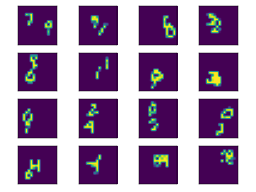

Input 



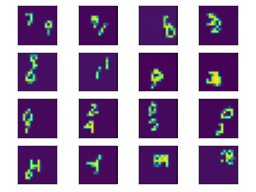

Prediction from states in all layers



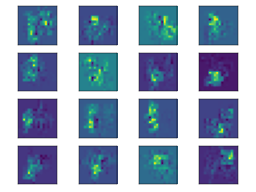

Prediction from state in deepest layer



TEST DATA


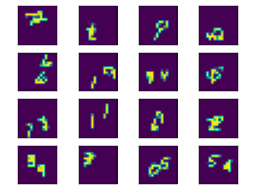

Input 



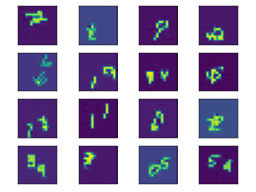

Prediction from states in all layers



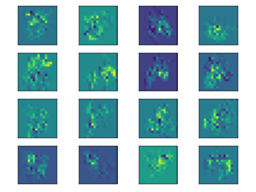

Prediction from state in deepest layer



In [ ]:
# Visualize batch of inputs and predictions
# We use the last frame of the sequence, since it is the most refined estimation

print("TRAIN DATA")
Image(open('./figures/Mnist-Train-v0input.png','rb').read())
print("Input \n")
Image(open('./figures/Mnist-Train-v0pred_h.png','rb').read())
print("Prediction from states in all layers\n")
Image(open('./figures/Mnist-Train-v0pred_g.png','rb').read())
print("Prediction from state in deepest layer\n")

print("\n\nTEST DATA")
Image(open('./figures/Mnist-Test-v0input.png','rb').read())
print("Input \n")
Image(open('./figures/Mnist-Test-v0pred_h.png','rb').read())
print("Prediction from states in all layers\n")
Image(open('./figures/Mnist-Test-v0pred_g.png','rb').read())
print("Prediction from state in deepest layer\n")

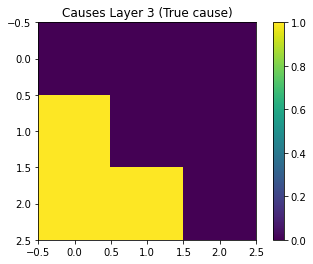

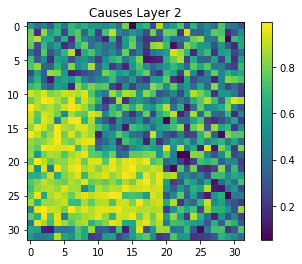

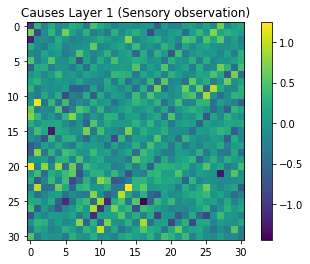

In [ ]:
"""
Second order perception in the visual domain

Here, visual content is defined via second order statistics, i.e. without first-order perceptual content.
Recognizing second-order objects requires top-down prediction of precision.
This renders second order perception a suitable task to contrast GPC with other architectures.

This script generates data comparable to pubmed.ncbi.nlm.nih.gov/25823866 with
convolutional neural networks as the generative model.
Gaussian noise enters the data generating process via parameter initialization.

Second order perception requires the estimated precision to be dependent on hidden states
in higher layers, so that objects and their precision are predicted jointly.

"""

import torch
import matplotlib.pyplot as plt
from torch import nn

# Layer 3 causes: Position of object
input = torch.zeros([1,1,3,3])
input[:,:,2,1] = 1
input[:,:,2,0] = 1
input[:,:,1,0] = 1

# Layer 2 causes: Position of object in sensory space
m = nn.ConvTranspose2d(1, 10, (10, 10), stride=10, padding=(0, 0), output_padding=(2, 2), bias=None)
torch.nn.init.ones_(m.weight);
output = m(input).mean(dim=1).unsqueeze(1)
output = torch.sigmoid(output*2+(torch.randn_like(output))) # add innovation

# Layer 1 causes (observable): Object in sensory space
m = nn.Conv2d(1, 10, (2, 2), stride=1, bias=False, padding_mode="reflect")
torch.nn.init.normal_(m.weight, 0, 1);
output2 = m((output*torch.randn_like(output))).mean(dim=1).unsqueeze(1);
output2 = output2;

plt.imshow(input.detach().numpy().reshape(input.shape[-1],input.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 3 (True cause)");
plt.show();

plt.imshow(output.detach().numpy().reshape(output.shape[-1],output.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 2");
plt.show();

plt.imshow(output2.detach().numpy().reshape(output2.shape[-1],output2.shape[-1]));
plt.colorbar();
plt.title("Causes Layer 1 (Sensory observation)");
plt.show();


In [ ]:
# A bias for inference?

# Comparing gradient based predictive coding with and without activity gain optimization:
# 1) with activity gain : output =  weights(activity * activity_gain) + weights_bias
# 2) without activity gain : output = weights(activity) + weights_bias
# Activity gain = Modulatory (multiplicative) bias on activity

# Experiment:
#     - Pure inference (no weights optimization)
#     - randomly initialised ( N(0,1) ) activity
#     - optimize activity such that projection through weights fits another randomly initialised ( N(0,1) ) tensor

# Evaluation:
#     - updates up to convergence (loss <= 0.01)


import torch, numpy as np

UPDATES = 1000 # maximum allowed updates
length = np.array([0,0]) # store final results

for optimize_gain in [0,1]:
    for i in range(10):
        d = torch.randn(64).requires_grad_()  # activity
        b = torch.randn(64).requires_grad_()  # activity gain (multiplicative bias)
        w = torch.nn.Linear(64, 16, False)  # weights (optionally with additive bias)
        t = torch.randn(16)  # target
        opt_d = torch.optim.SGD([d], 0.1)  # activity optimizer
        opt_b = torch.optim.SGD([b], 0.1)  # activity gain optimizer

        for i in range(UPDATES):
            opt_d.zero_grad()

            if optimize_gain == 0:
                loss = torch.mean(((w(d)) - t) ** 2) # no multiplicative bias on activity
            else:
                loss = torch.mean(((w(d*b)) - t) ** 2)

            loss.backward()

            opt_d.step() # step activity
            if optimize_gain == 1: opt_b.step()  # step activity gain

            if loss <= 0.01 or i == (UPDATES-1):
                length[optimize_gain] += i
                break

length = length/10
print("Average updates to convergence without activity gain: ", length[0])
print("Average updates to convergence with activity gain: ", length[1])

Average updates to convergence without activity gain:  884.8
Average updates to convergence with activity gain:  290.7


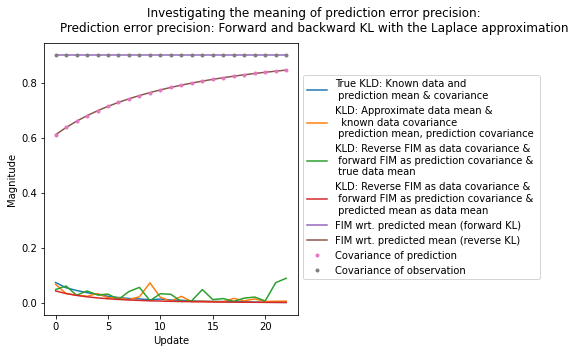

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
from torch.autograd import grad
from torch.distributions import *
from torch.distributions.multivariate_normal import MultivariateNormal

"""
Can we compute the full KLD instead of the ELBO under the Laplace assumption?

Laplace approximation:
- Approximate a posterior distribution with a Gaussian centered at the maximum a posteriori (MAP) estimate
- Replaces the problem of integrating a function with the problem of maximizing it, i.e. an optimization problem
- The covariance of the Gaussian is determined by the Hessian matrix of log f(θ) at the maximum point (Mackay, 1998)

KL Divergence:
- forward KLD(p,q) --> mode averaging (--> Variational Inference..)
- backward KLD(p,q) --> mode fitting (--> Expectation propagation..)

Motivation: The prediction error precision in PCNs already measures 
all relevant quantities for both divergences.

In the context of predictive coding, we use the Laplace assumption in order to 
compute the full predictive and data distribution (which normally is untractable).

The FIM can be obtained A) analytically, as the Hessian of the prediction error (loss) function.
Or it can be estimated B) empirically from first order information (= empricial FIM = prediction error precision). 

We compare three settings for the analytical FIM:

1) No Laplace assumption: 
KL divergence with know mean and covariance of data and prediction
2) Laplace assumption for predictive distribution: 
      Same setting as 1) but the prediction covariance is obtained with 
      the Fisher Information Metric (FIM) (= Hessian of forward KL)
3) Laplace assumption for predictive and data distribution: 
      Same setting as 2) but both prediction and data covariances 
      are obtained with the FIM (= Hessian of forward and backward KL)
    
"""

# Motivation:
# Empirically, the prediction error precision seems to measure forward and backward FIM already
# when either the input or the prediction is fixed/ignored

# Hypothesis: PC precision allows to compute full KL loss instead of ELB0
# Using 1) the Laplace approximation, 2) approximated data mean (= precision weighted prediction mean)
# and  3) forward and reverse KL loss (= precision weighted MSE)
# we can encode data mean, covar and prediction covar as functions of the prediction mean
# (Variational Inference <-> Expectation Propagation ?..)

# create data
x = torch.ones([50])
loss = torch.nn.MSELoss()
data_mean = torch.tensor([0.3]).float() # unknown to the model (will be approximated as the mean of iterated prediction)
data_covar = torch.eye(1).float() * 0.9 # unknown to the model (will be approximated as the reverse KL FIM under the Laplace approximation)
true_data = MultivariateNormal(data_mean, data_covar)

# priors on model parameters
mean = torch.tensor([0.5]).float().requires_grad_() # known to the model
covar = (torch.eye(1).float() * .5).requires_grad_() # known to the model (will be approximated as the forward KL FIM under the Laplace approximation)
FIM_mean = (torch.eye(1).float() * 1).requires_grad_() # prior on FIM
estimated_data_mean = 0

# optimizers
opt_mean = torch.optim.SGD([mean], 0.1)
opt_covar = torch.optim.SGD([covar], 0.1)

# logging
errors, true_errors, FIM_errors, FIM_errors_approx_mean = [], [], [], []
true_FIM_mean_l, true_FIM_covar_l, true_FIM_mean_data_l = [], [], []
est_FIM_mean_l, est_FIM_covar_l = [], []
covars_data, covars = [], []
true_errors_exact = []

# experiment settings
optimize = True
nr_samples = 50


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for i in x:
    # sample observation and prediction
    opt_mean.zero_grad(), opt_covar.zero_grad()
    pred = MultivariateNormal(mean, covar)

    # simplification: compute estimated data mean via MSE instead of KL ( = precision weighted MSE)
    # so that prediction errors are computed wrt. an approximate data mean
    # (in a predictive coding network, this is just the mean state estimate, when optimized towards minimizing PE from the outgoing prediction)
    for sample in range(nr_samples):
        estimated_data_mean += true_data.sample()
    estimated_data_mean = estimated_data_mean / nr_samples
    data = MultivariateNormal(estimated_data_mean, data_covar)

    # Analytical covariance without Laplace assumption:
    # Model maintains mean and covariance explicitely
    # Problem: Requires known data and prediction covariance
    true_KL_error = kl_divergence(pred, data)
    true_KL_error_data = kl_divergence(data, pred)
    true_KL_error_exact = kl_divergence(true_data, pred)

    if optimize: # optimize prediction
        true_KL_error.backward()
        opt_mean.step()
        opt_covar.step()
        true_errors.append(true_KL_error.detach()) # logging
        true_errors_exact.append(true_KL_error_exact.detach())
    else: # compute exact FIM
        # Forward FIM: compute Hessian of forward KL loss wrt. predicted mean
        grad11 = grad(true_KL_error, mean, create_graph=True)  # first derivative
        grad21 = grad(grad11[0][0], mean, create_graph=True)  # second derivative
        FIM_mean = grad21[0].detach()**-1
        FIM_mean = FIM_mean.unsqueeze(-1).requires_grad_() # prepare FIM for optimization as prediction covariance
        pred_FIM = MultivariateNormal(mean, FIM_mean) # the prediction distribution with known FIM as covariance

        # logging
        covars.append(pred.covariance_matrix.detach().numpy()[0, 0])
        covars_data.append(data.covariance_matrix.detach().numpy()[0, 0])
        true_FIM_mean_l.append(FIM_mean.detach())

        # Reverse FIM: compute Hessian of reverse KL loss wrt. predicted mean
        grad11 = grad(true_KL_error_data, mean, create_graph=True)  # first derivative
        grad21 = grad(grad11[0][0], mean, create_graph=True)  # second derivative
        FIM_mean_data = grad21[0].detach()**-1
        FIM_mean_data = FIM_mean_data.unsqueeze(-1).detach() # prepare the known FIM to replace the unknown data covariance in the loss

        # encode data distribution with reverse FIM as covariance and approximated mean (from bottom-up prediction error)
        data_FIM = MultivariateNormal(estimated_data_mean, FIM_mean_data) # the data distribution with known FIM as covariance
        true_FIM_mean_data_l.append(FIM_mean_data.detach())
        FIM_errors.append(kl_divergence(pred_FIM, data_FIM).detach())

        # encode data distribution with reverse FIM as covariance and predicted mean (from top-down predicted mean)
        data_FIM_approx_mean = MultivariateNormal(mean, FIM_mean_data)
        FIM_errors_approx_mean.append(kl_divergence(pred_FIM, data_FIM_approx_mean).detach())

    optimize = not optimize  # switch between optimizing the model and measuring the FIM

ax1.plot(true_errors_exact[2:], label="True KLD: Known data and \n prediction mean & covariance")
ax1.plot(true_errors[2:], label="KLD: Approximate data mean &  \n  "
                                "known data covariance \n prediction mean, "
                                "prediction covariance")
ax1.plot(FIM_errors[2:], label="KLD: Reverse FIM as data covariance & \n "
                               "forward FIM as prediction covariance & \n "
                               "true data mean")
ax1.plot(FIM_errors_approx_mean[2:], label="KLD: Reverse FIM as data covariance & \n "
                               "forward FIM as prediction covariance & \n "
                               "predicted mean as data mean")
ax1.plot(true_FIM_mean_l[2:], label="FIM wrt. predicted mean (forward KL)")
ax1.plot(true_FIM_mean_data_l[2:], label="FIM wrt. predicted mean (reverse KL)")
ax1.plot(covars[2:], '.', label="Covariance of prediction")
ax1.plot(covars_data[2:], '.', label="Covariance of observation")
ax1.set_ylabel("Magnitude")
ax1.set_xlabel("Update")
ax1.legend(bbox_to_anchor=(1.0, 0.9), bbox_transform=ax1.transAxes)
ax2.set_visible(False)
plt.suptitle("Investigating the meaning of prediction error precision:\nPrediction error precision: Forward and backward KL with the Laplace approximation")
plt.show()
plt.close()

